# 정률투자법

첫 예제로 챕터 1에 소개된 첫 번째 투자 전략인 정률 투자법을 준비한 것은 단지 책에 처음 등장했기 때문만은 아닙니다.

정률 투자법은 투자법 그 자체로는 이해하기 쉽고 굉장히 간단한 데에 비해 실제 Back-Testing을 구현하다 보면 복잡한 전략에서도 공통적으로 사용하게 될

- 리밸런싱
- 복수의 DataFeed
- Timer 혹은 Indicator를 이용한 주기적 시그널 생성

같은 요소들을 모두 포함하고 있기 때문입니다.

## 전략 소개
- 기대 CAGR: '주식지수 CAGR + 채권지수 CAGR'의 평균 + 1%
- 매수 전략: 총 자산 중 50%를 코스피 지수에 투자, 나머지 50%는 국채 3년물에 투자
- 매도 전략: 월 1회 리밸런싱(코스피 50%, 채권50%로 재조정)

In [1]:
from lib.utils.logging import configure_logger
%load_ext autoreload
%autoreload 2
configure_logger()

## Data preparation
코스피 지수를 추종하는 ETF들의 과거 데이터가 충분치 않아 코스피 지수 자체로 가격데이터를 대체합니다. 국채 3년물의 경우도 마찬가지, 한국거래소에 등록된 국채 3년물들의 경우 최근에 등록된 것들이 많아 나스닥의 iShare 장기채 ETF(TLT)로 대체합니다. 책과는 달리 장기채 ETF로 대체한 이유는 더 장기간 데이터를 구할 수 있고, 또 아이디어 자체가 상관관계가 적은 종목으로 포트폴리오를 구성해서 주기적으로 밸런스를 잡는 것이기 때문에 장기/단기의 구분이 크게 중요하지 않다고 생각해서 입니다.

In [2]:
from lib.utils.data_utils import load_data, sync_market_days

kospi_df = load_data('^KS11')
tlt_df = load_data('TLT')

# (중요!!) 서로 다른 거래소의 종목 혹은 지수로 포트폴리오를 구성하는 경우 거래일의 교집합을 사용합니다.
kospi_df, tlt_df = sync_market_days(kospi_df, tlt_df)

/Users/s_park/opt/anaconda3/envs/backtrader/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Develope your strategy

lib.strategies.FixedPercentageStrategy를 참고하시기 바랍니다.

## Run back-test.

In [3]:
import backtrader as bt
from datetime import date

from lib.strategies.fixed_percentage_strategy import FixedPercentageStrategy

# Create a backtest runtime.
cerebro = bt.Cerebro()
cerebro.addstrategy(FixedPercentageStrategy)
initial_cash = 10000000
cerebro.broker.setcash(initial_cash)
cerebro.broker.setcommission(commission=0.00165)

# Feed Data.
kospi_data = bt.feeds.PandasData(dataname=kospi_df)
cerebro.adddata(kospi_data, name='KOSPI')
tlt_data = bt.feeds.PandasData(dataname=tlt_df)
cerebro.adddata(tlt_data, name='TLT')

# Data analyzers.
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='draw_down')
cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='positions_value', cash=True, headers=True)

# Run it!
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
res = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000000.00
Final Portfolio Value: 27287033.28


## Visualize your strategy

<IPython.core.display.Javascript object>


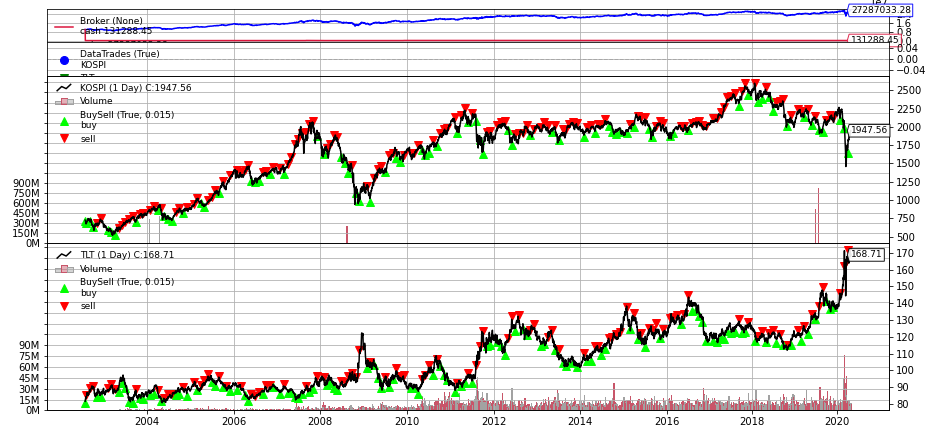

[[<Figure size 936x432 with 6 Axes>]]

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,6)
cerebro.plot()

or 
## Analyze the performance by yourself.

In [5]:
%matplotlib inline
import empyrical as ep
import pandas as pd

from lib.utils.analyzer_utils import annual_return_to_df, positions_value_to_df

fixed_percentage_annual_return_df = annual_return_to_df(res[0].analyzers.annual_return.get_analysis())
fixed_percentage_positions_value_df = positions_value_to_df(res[0].analyzers.positions_value.get_analysis(), enrich_total=True, total_col_name='total')
sharpe_ratio = res[0].analyzers.sharpe.get_analysis()['sharperatio']
mdd = res[0].analyzers.draw_down.get_analysis()["max"]["drawdown"]
cagr = ep.cagr(fixed_percentage_positions_value_df['total'].pct_change(), period="daily", annualization=None)
 
fixed_percentage_report_df = pd.DataFrame(
    dict(
        initial_value = initial_cash,
        final_value = cerebro.broker.get_value(),
        period_start = fixed_percentage_positions_value_df.index.min(),
        period_end = fixed_percentage_positions_value_df.index.max(),
        sharpe_ratio = sharpe_ratio,
        mdd = mdd,
        cagr = cagr
    ),
    index=['FixedPercentage']
)

pd.set_option('float_format', '{:.3f}'.format)
fixed_percentage_report_df

,initial_value,final_value,period_start,period_end,sharpe_ratio,mdd,cagr
FixedPercentage,10000000,27287033.281,2002-07-30,2020-04-29,0.513,27.779,0.061


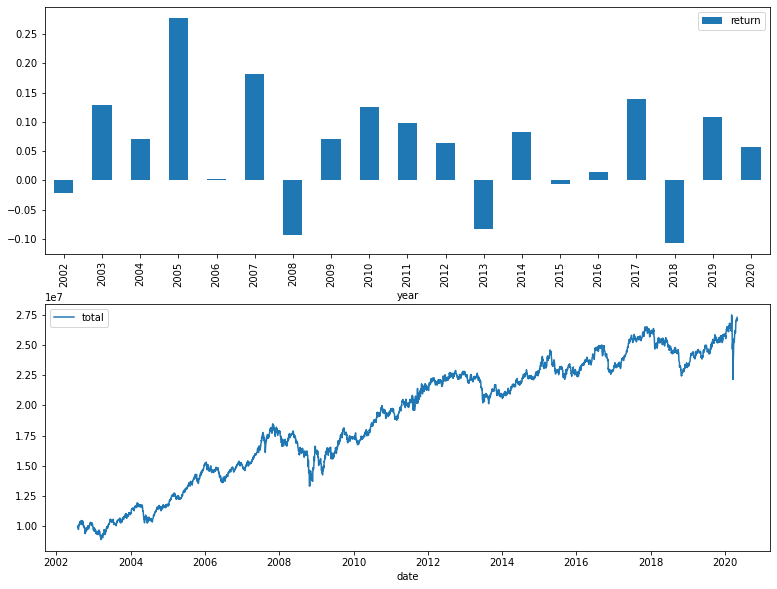

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


fixed_percentage_annual_return_df.plot.bar(ax=ax1)
fixed_percentage_positions_value_df[['total']].plot(ax=ax2)

상당히 인상적인 결과가 나왔네요.
2002년 8월부터 2020년 5월에 가까운 기간동안 연복리(CAGR) 6%이상의 수익을 거두었고 최대 하락폭(MDD)도 28%정도로 선방한 것이 보이네요.
리스크 대비 투자 가치를 보여주는 sharpe ratio도 0.5이상으로 나쁘지는 않네요. 이 결과가 무엇을 의미하는지 다른 전략을 테스트한 결과와 비교해서 보도록 하겠습니다.

첫 예제의 단순한 전략의 경우엔 아래 시나리오랑 비교해 보도록 하겠습니다.

- 투자 초기 KOSPI 100% 보유
- 투자 초기 TLT 100% 보유
- 투자 초기 KOSPI, TLT 각각 50% 보유

# Benchmark test

In [7]:
# Scenario 1
from lib.strategies.hold_all_strategy import HoldAllStrategy

cerebro = bt.Cerebro()
cerebro.addstrategy(HoldAllStrategy, buy_date='2002-07-30')
cerebro.broker.setcash(initial_cash)
cerebro.broker.setcommission(commission=0.00165)

# Feed Data.
kospi_data = bt.feeds.PandasData(dataname=kospi_df)
cerebro.adddata(kospi_data, name='KOSPI')


# Data analyzers.
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='draw_down')
cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='positions_value', cash=True, headers=True)

# Run it!
kospi_res = cerebro.run()
kospi_annual_return_df = annual_return_to_df(kospi_res[0].analyzers.annual_return.get_analysis())
kospi_positions_value_df = positions_value_to_df(kospi_res[0].analyzers.positions_value.get_analysis(), enrich_total=True, total_col_name='total')
sharpe_ratio = kospi_res[0].analyzers.sharpe.get_analysis()['sharperatio']
mdd = kospi_res[0].analyzers.draw_down.get_analysis()["max"]["drawdown"]
cagr = ep.cagr(kospi_positions_value_df['total'].pct_change(), period="daily", annualization=None)

kospi_report_df = pd.DataFrame(
    dict(
        initial_value = initial_cash,
        final_value = cerebro.broker.get_value(),
        period_start = kospi_positions_value_df.index.min(),
        period_end = kospi_positions_value_df.index.max(),
        sharpe_ratio = sharpe_ratio,
        mdd = mdd,
        cagr = cagr
    ),
    index=['HoldStrategy_KOSPI']
)

pd.set_option('float_format', '{:.3f}'.format)

In [8]:
# Scenario 2
from lib.strategies.hold_all_strategy import HoldAllStrategy

cerebro = bt.Cerebro()
cerebro.addstrategy(HoldAllStrategy, buy_date='2002-07-30')
cerebro.broker.setcash(initial_cash)
cerebro.broker.setcommission(commission=0.00165)

tlt_data = bt.feeds.PandasData(dataname=tlt_df)
cerebro.adddata(tlt_data, name='TLT')


# Data analyzers.
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='draw_down')
cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='positions_value', cash=True, headers=True)

# Run it!
res = cerebro.run()
tlt_annual_return_df = annual_return_to_df(res[0].analyzers.annual_return.get_analysis())
tlt_positions_value_df = positions_value_to_df(res[0].analyzers.positions_value.get_analysis(), enrich_total=True, total_col_name='total')
sharpe_ratio = res[0].analyzers.sharpe.get_analysis()['sharperatio']
mdd = res[0].analyzers.draw_down.get_analysis()["max"]["drawdown"]
cagr = ep.cagr(tlt_positions_value_df['total'].pct_change(), period="daily", annualization=None)

tlt_report_df = pd.DataFrame(
    dict(
        initial_value = initial_cash,
        final_value = cerebro.broker.get_value(),
        period_start = kospi_positions_value_df.index.min(),
        period_end = kospi_positions_value_df.index.max(),
        sharpe_ratio = sharpe_ratio,
        mdd = mdd,
        cagr = cagr
    ),
    index=['HoldStrategy_TLT']
)

In [9]:
# Scenario 3

from lib.strategies.hold_all_strategy import HoldAllStrategy

cerebro = bt.Cerebro()
cerebro.addstrategy(HoldAllStrategy, buy_date='2002-07-30')
cerebro.broker.setcash(initial_cash)
cerebro.broker.setcommission(commission=0.00165)

kospi_data = bt.feeds.PandasData(dataname=kospi_df)
cerebro.adddata(kospi_data, name='KOSPI')

tlt_data = bt.feeds.PandasData(dataname=tlt_df)
cerebro.adddata(tlt_data, name='TLT')


# Data analyzers.
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='draw_down')
cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='positions_value', cash=True, headers=True)

# Run it!
res = cerebro.run()
all_annual_return_df = annual_return_to_df(res[0].analyzers.annual_return.get_analysis())
all_positions_value_df = positions_value_to_df(res[0].analyzers.positions_value.get_analysis(), enrich_total=True, total_col_name='total')
sharpe_ratio = res[0].analyzers.sharpe.get_analysis()['sharperatio']
mdd = res[0].analyzers.draw_down.get_analysis()["max"]["drawdown"]
cagr = ep.cagr(all_positions_value_df['total'].pct_change(), period="daily", annualization=None)

all_report_df = pd.DataFrame(
    dict(
        initial_value = initial_cash,
        final_value = cerebro.broker.get_value(),
        period_start = kospi_positions_value_df.index.min(),
        period_end = kospi_positions_value_df.index.max(),
        sharpe_ratio = sharpe_ratio,
        mdd = mdd,
        cagr = cagr
    ),
    index=['HoldStrategy_ALL']
)

In [11]:
import pandas as pd
overall_report_df = pd.concat([fixed_percentage_report_df, kospi_report_df, tlt_report_df, all_report_df])
overall_report_df

,initial_value,final_value,period_start,period_end,sharpe_ratio,mdd,cagr
FixedPercentage,10000000,27287033.281,2002-07-30,2020-04-29,0.513,27.779,0.061
HoldStrategy_KOSPI,10000000,26698074.753,2002-07-30,2020-04-29,0.299,54.400,0.060
HoldStrategy_TLT,10000000,20519888.023,2002-07-30,2020-04-29,0.269,28.396,0.044
HoldStrategy_ALL,10000000,23608981.388,2002-07-30,2020-04-29,0.373,37.254,0.052


물론 책을 집필할 때 백테스트를 수행하고 그 결과를 토대로 작성했겠지만, 또 너무 책내용 그대로의 결과나 나오니 놀랍네요.

(기대 CAGR: '주식지수 CAGR + 채권지수 CAGR'의 평균 + 1%)

사실 다양한 전략을 여러 데이터를 가지고 백테스트를 수행하다보면 작은 파라미터 설정, 테스트 기간에 따라서도 크게 다른 결과를 얻는 경우가 많습니다.
개인적 견해로 그런 전략들은 과적합의 우려가 있어서 지양하는 편인데 이 단순한 정률투자법의 경우 책에서 언급한 테스트 기간과 5년이상 차이가 남에도 불구하고 거의 같은 결과를 보여준다는 것은 그 만큼 이 전략에 일관성을 기대할 수 있다는 의미로 해석이 되네요.

개별 시나리오와의 비교는 전부 하기는 힘들고.. 가장 연복리이율이 근접한 코스피의 사례와 비교해볼 때 이율은 거의 같으나 MDD가 거의 두배 가까운 차이를 보여서 어느 쪽 전략이 더 정신적 스트레스가 적을지 선명하게 보여주네요.

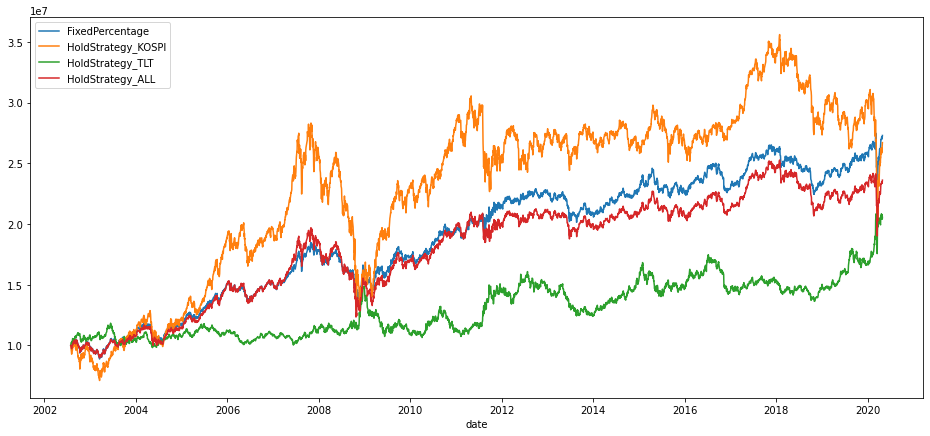

In [16]:
df = pd.DataFrame()
df['FixedPercentage'] = fixed_percentage_positions_value_df['total']
df['HoldStrategy_KOSPI'] = kospi_positions_value_df['total']
df['HoldStrategy_TLT'] = tlt_positions_value_df['total']
df['HoldStrategy_ALL'] = all_positions_value_df['total']

plt.rcParams["figure.figsize"] = (16,7)
df.plot()

각 시나리오의 시기별 자산가치를 차트로 그리고 보면 파란선으로 표시된 정률투자법의 경우 거의 부침이 없이 꾸준히 우상향을 보이고 있는 반면, 대부분의 시기에 정률투자법보다 높은 수익을 보이고 있는 코스피보유 시나리오의 경우 금융위기와 코로나 위기에 개박살이 나는 모습을 볼 수 있네요. 멘탈좀 나갈듯.

## 맺음

사실 정률 투자법은 지나치게 방어적이고 지루한 전략이라 그 자체로는 매력이 없지만 서두에 언급한 대로 다른 전략을 개발하고 테스트할 수 있는 토대로 삼기에는 충분하다고 생각되서 예제를 준비해 보았습니다. 애석하게 현재 BackTrader는 다양한 전략을 하나의 런타임에서 독립적으로 실행할 방법이 없어 보입니다.

그런 이유로 뒤의 벤치마크 테스트의 코드가 지나치게 길어진 감이 있습니다만. 반복되는 코드를 함수로 리팩토링해서 코드의 양을 줄일 수 있겠지요.
그럼 여력이 되는대로 책에 소개된 전략들을 꾸준히 구현해서 올려보도록 하겠습니다.